# Results on the ZINC dataset (with the model trained by the authors)

In [4]:
%load_ext autoreload
%autoreload 2

import pubchempy as pcp
import seaborn as sns

from tqdm import tqdm
from rdkit import RDLogger

from rdkit import Chem
from rdkit.Chem import Crippen, QED
from rdkit.Chem import RDConfig

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import sascorer

# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
vae = VAEUtils(directory='../models/zinc')
vae_properties = VAEUtils(directory='../models/zinc_properties')

/home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!


/home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!


### Figure 2: Representations of the sampling results from the variational autoencoder

a) Kernel Density Estimation (KDE) of each latent dimension of the autoencoder, i.e., the distribution of encoded molecules along each dimension of our latent space representation

![](../aux_data/fig2a.PNG)


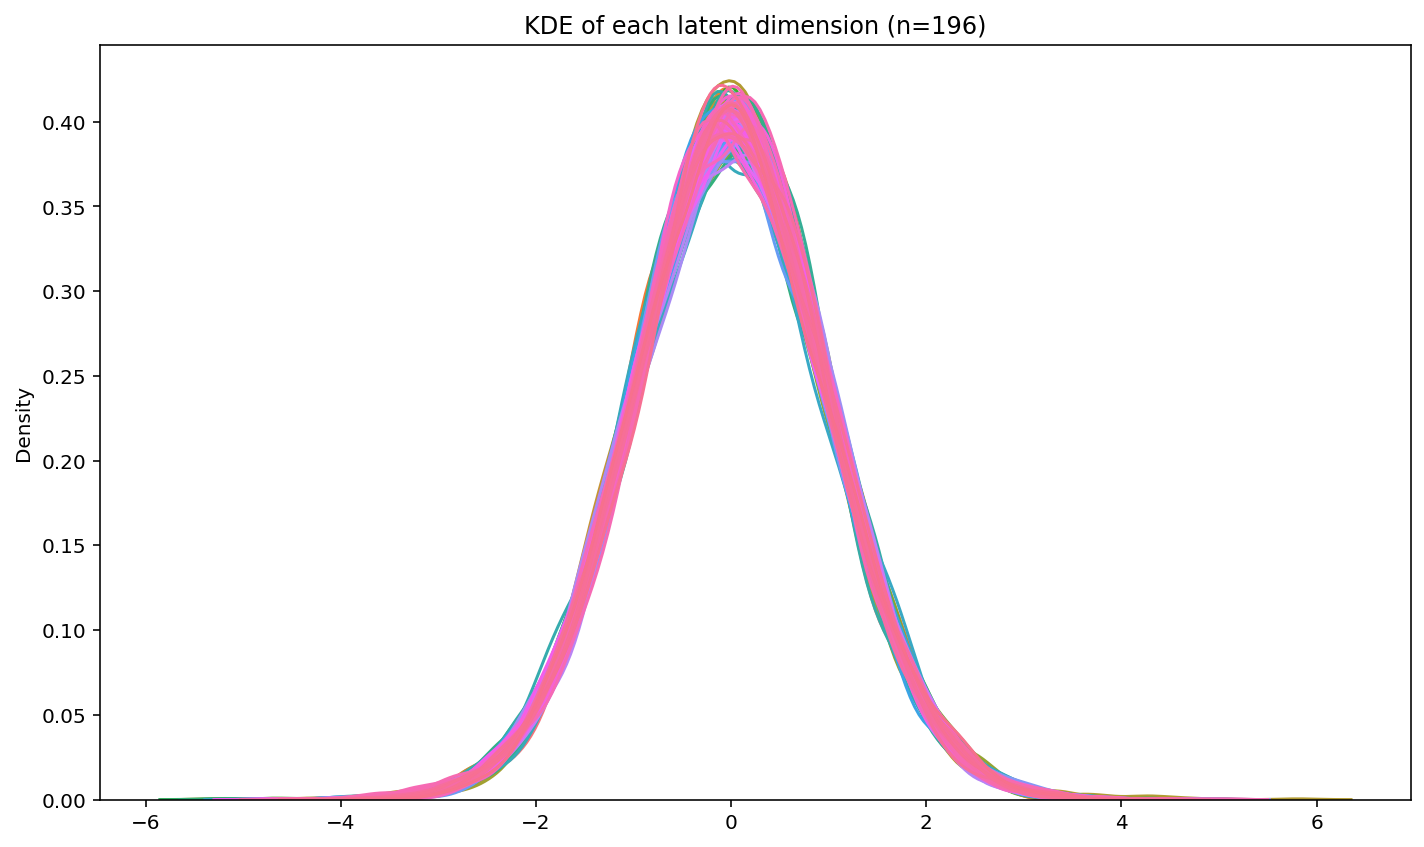

In [6]:
# encode 5000 random molecules and plot a kernel density estimate of their latent representation
# to show that the latent variables follow a gaussian distribution

rand_5000_molecules = vae.random_molecules(size=5000)
X_rand_5000_molecules = vae.smiles_to_hot(rand_5000_molecules,canonize_smiles=True)
z_rand_5000_molecules = vae.encode(X_rand_5000_molecules)

# Set up the plotting environment
plt.figure(figsize=(10, 6))

# For each dimension in the data, compute and plot the KDE
for dim in range(z_rand_5000_molecules.shape[1]):
    sns.kdeplot(z_rand_5000_molecules[:, dim], legend=False, color=sns.color_palette("husl", 196)[dim])

plt.title('KDE of each latent dimension (n=196)')
plt.tight_layout()
plt.show()

b) histogram of sampled
molecules for a single point in the latent space; the distances of the molecules from the original query are shown by the lines corresponding to the right axis


![](../aux_data/fig2b.PNG)

In [7]:
# no idea which molecule exactly they used for this plot
# it should be a "sample FDA-approved drug molecule"
# here I just picked a random one from the ZINC dataset
molecule = mu.canon_smiles("C[C@@H]1C[C@H]1c1ccc(C[NH+](C)Cc2nnsc2Cl)o1")
print(molecule)
X = vae.smiles_to_hot(molecule,canonize_smiles=True)
z = vae.encode(X)

decode_attempts = 100

Z = np.tile(z, (decode_attempts, 1))
X = vae.decode(Z)
smiles = vae.hot_to_smiles(X, strip=True)
df = vae.prep_mol_df(smiles, z)

print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)

C[C@@H]1C[C@H]1c1ccc(C[NH+](C)Cc2nnsc2Cl)o1
Found 4 unique mols, out of 31
SMILES
 0    C[C@@H]1C[C@H]1c1ccc(C[NH+](C)Cc2nnsc2Cl)o1
1    C[C@@H]1C[C@H]1c1ccc(C[NH+](C)Cc2nsnc2Cl)o1
2    C[C@@H]1C[C@H]1c1ccc(C[NH+](C)Cc2ncsc2Cl)o1
3    C[C@@H]1C[C@H]1c1ccc([C@H+](C)Cc2ncsc2Cl)o1
Name: smiles, dtype: object


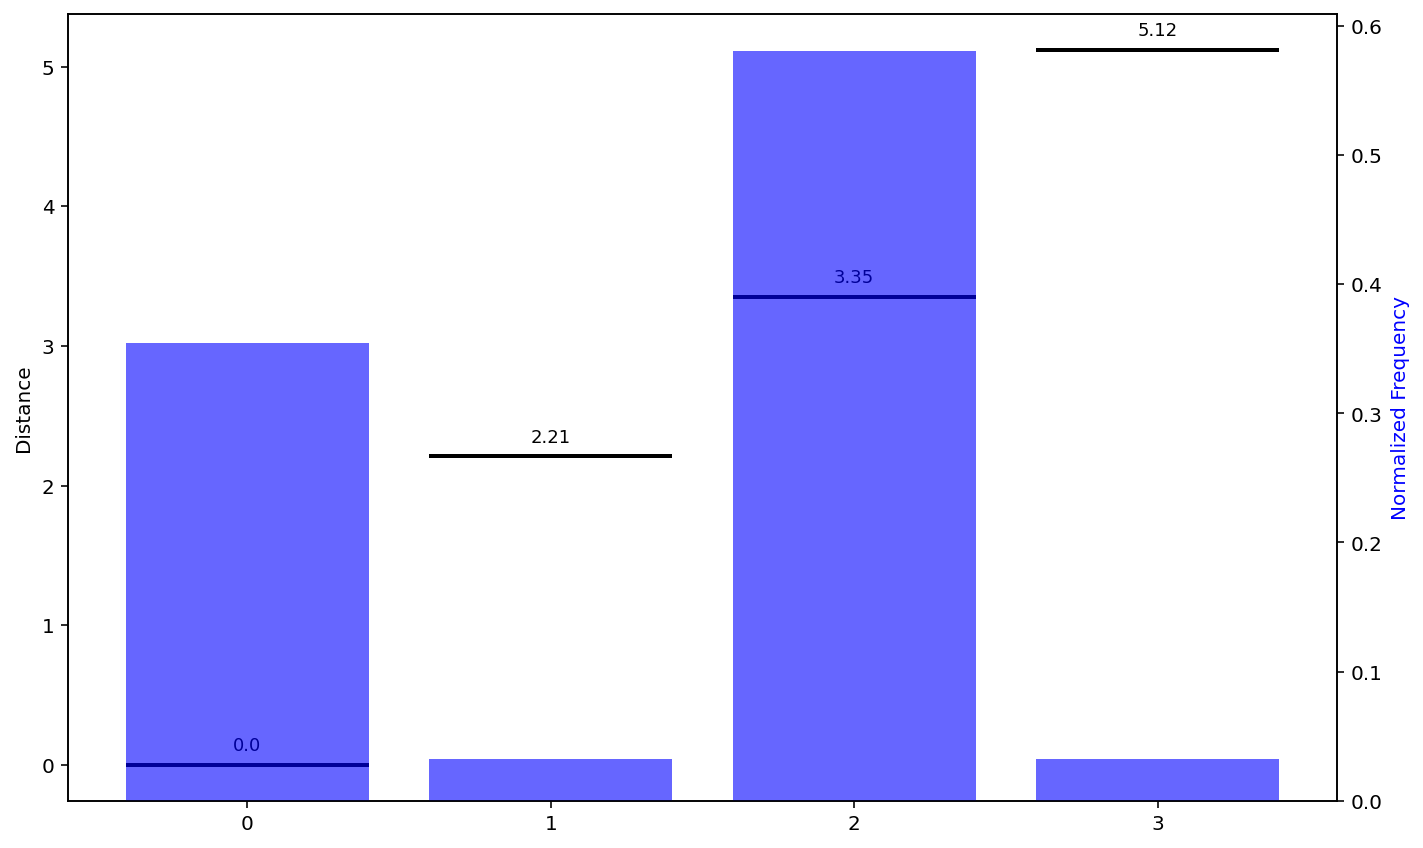

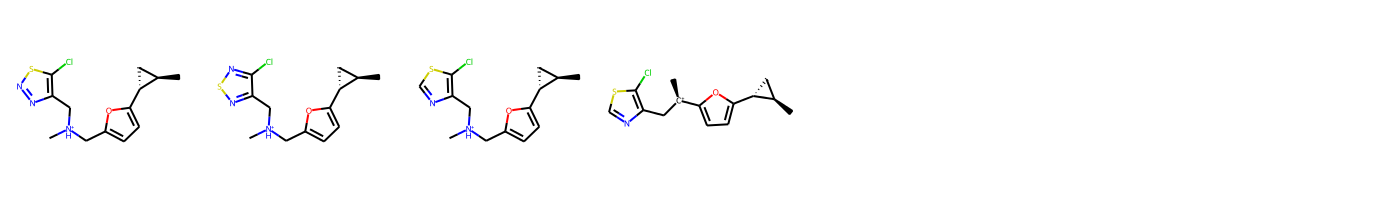

In [8]:
# Create a new figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a secondary y-axis for the frequency bars
ax2 = ax1.twinx()

# Plot the bar chart using the frequency column on ax2
bars = ax2.bar(df.index, df['frequency'], alpha=0.6, label='Frequency', color='blue')

# Plot horizontal lines representing distance over each bar and annotate the distance value on ax1
for bar, distance in zip(bars, df['distance']):
    ax1.hlines(distance, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
    
    # Round the distance value to 2 decimal places
    rounded_distance = round(distance, 2)
    
    # Annotate the rounded distance value
    ax1.annotate(str(rounded_distance),
                 (bar.get_x() + bar.get_width()/2, distance),
                 textcoords="offset points",
                 xytext=(0,5),  # 5 points vertical offset
                 ha='center',
                 va='bottom',
                 fontsize=9,
                 color='black')

# Set the y-axis labels
ax1.set_ylabel('Distance', color='black')
ax2.set_ylabel('Normalized Frequency', color='blue')

# Set the x-axis ticks
ax1.set_xticks(df.index)
ax1.set_xticklabels(df.index)

plt.tight_layout()
plt.show()

display(PandasTools.FrameToGridImage(df,column='mol' , molsPerRow=7))

c) molecules sampled near the location of ibuprofen in latent space. The values below the molecules are the distance in latent space from
the decoded molecule to ibuprofen

![](../aux_data/fig2c.PNG)

Searching molecules randomly sampled from 40.00 std (z-distance) from the point
Found 19 unique mols, out of 392
SMILES
 0      CC(C)Cc1ccc(C(C)C(=O)O)cc1
1      FC(C)Cc1ccc(C(C)C(=O)O)cc1
2      CC(F)Cc1ccc(C(C)C(=O)O)cc1
3      CC(C)Cc1ccc(S(C)C(=O)O)cc1
4      CC(N)Cc1ccc(C(C)C(=O)O)cc1
5      CC(C)Cc1ccc(N(C)C(=O)O)cc1
6      CC(N)Cc1ccc(C(C)C(CO)O)cc1
7      CC(C)Cc1ccc(C(C)C(=O)OC)C1
8      CC(C)C1cccc(C(C)C(=O)O)cc1
9     CC(C)Cc1ccc(C(C)C(=O)OC)cc1
10    FC(C)Cc1ccc(C(C)C(=O)OC)cc1
11     CC(C)Sc1ccc(S(C)C(=O)O)cc1
12    CC(F)Cc1ccc(C(C)C(=O)OC)cc1
13    CC(C)Cc1ccc(S(C)C(=O)OC)cc1
14    FC(F)Cc1ccc(C(C)C(=O)OC)cc1
15    CC(C)Cc1ccc(N(C)C(=O)OC)cc1
16    CC(N)Cc1ccc(C(C)C(=O)OC)cc1
17    CC(C)Cc1ccc(C(C)C(=O)OCl)C1
18    CC(F)Cc1ccc(N(C)C(=O)OC)cc1
Name: smiles, dtype: object


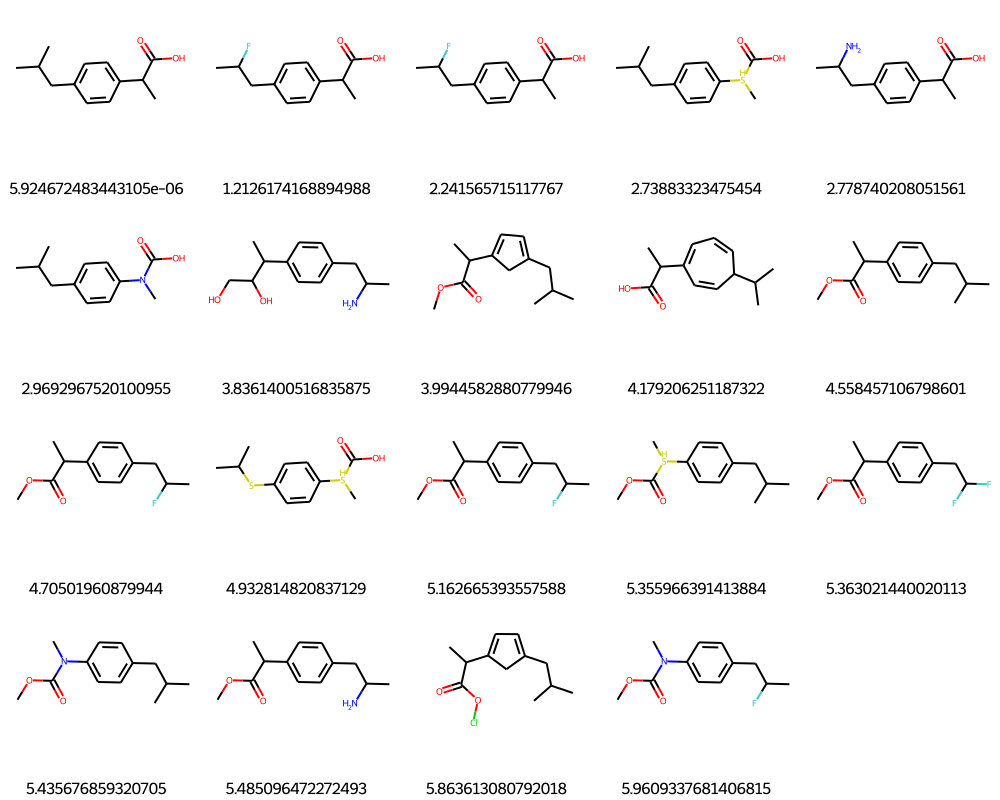

,smiles,distance,count,frequency,mol
0,CC(C)Cc1ccc(C(C)C(=O)O)cc1,0.000006,132,0.336735,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,FC(C)Cc1ccc(C(C)C(=O)O)cc1,1.212617,2,0.005102,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CC(F)Cc1ccc(C(C)C(=O)O)cc1,2.241566,44,0.112245,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CC(C)Cc1ccc(S(C)C(=O)O)cc1,2.738833,3,0.007653,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CC(N)Cc1ccc(C(C)C(=O)O)cc1,2.778740,41,0.104592,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [9]:
compound = pcp.get_compounds('Ibuprofen', 'name')[0]
smiles_1 = mu.canon_smiles(compound.isomeric_smiles)

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)

noise=40.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles(z_1, decode_attempts=2000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='distance',molsPerRow=5))
df.head()

d) slerp interpolation between two molecules in latent space using six steps of equal distance

![](../aux_data/fig2d.PNG)

/home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/scipy/spatial/_geometric_slerp.py:208: UserWarning: start and end are antipodes using the specified tolerance; this may cause ambiguous slerp paths
  warnings.warn("start and end are antipodes"


smiles                CCNCC(=O)c1ccc(OC(=O)CCC(C)C)c(C(N)=O)c1
distance                                               6.51447
count                                                        2
frequency                                                  0.2
mol          <img data-content="rdkit/molecule" src="data:i...
Name: 0, dtype: object
smiles                CCCNC(=O)N1ccc(OC(=O)CC(C)C)cc(C(N)=O)c1
distance                                               9.46617
count                                                        1
frequency                                                0.125
mol          <img data-content="rdkit/molecule" src="data:i...
Name: 0, dtype: object
smiles                CCCNC(=O)Cc1cc(SC(=O)CC(C)C)cc(C(C)=O)c1
distance                                               11.4203
count                                                        1
frequency                                             0.333333
mol          <img data-content="rdkit/molecule" src="data:i...
Name: 0, 

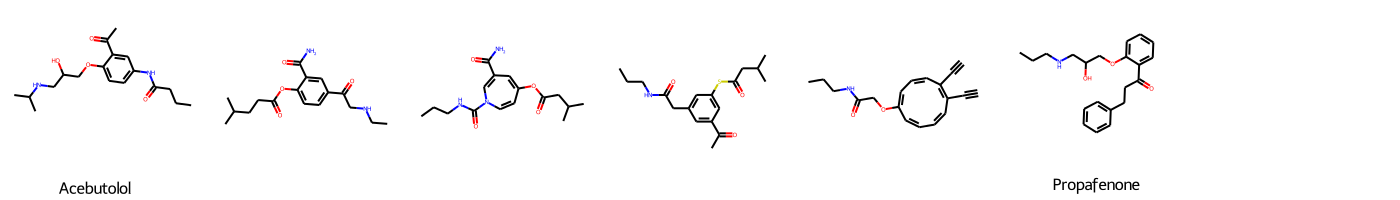

In [10]:
# prepare interpolation
acebutolol_compound = pcp.get_compounds('Acebutolol', 'name')[0]
propafenone_compound = pcp.get_compounds('Propafenone', 'name')[0]

smiles_ace = mu.canon_smiles(acebutolol_compound.isomeric_smiles)
smiles_pro = mu.canon_smiles(propafenone_compound.isomeric_smiles)
molecule_smiles = [smiles_ace, smiles_pro]

slerp_df = pd.DataFrame({'smiles': molecule_smiles, "slerp": [0.0, 1.0], "name": ["Acebutolol", "Propafenone"]})
slerp_df["mol"] = slerp_df['smiles'].apply(mu.smiles_to_mol)

X_mols = vae.smiles_to_hot(molecule_smiles,canonize_smiles=True)
z_mols = vae.encode(X_mols)

from scipy.spatial import geometric_slerp

for i in range(1, 6):
    fraction = i / 7.0

    decode_attempts = 500

    sphere_center = 0.5 * z_mols[0] + 0.5 * z_mols[1]

    start_mol_z = z_mols[0] - sphere_center
    end_mol_z = z_mols[1] - sphere_center

    norm_scale = np.linalg.norm(start_mol_z)
    assert np.linalg.norm(start_mol_z) == np.linalg.norm(end_mol_z)

    start_mol_z /= norm_scale
    end_mol_z /= norm_scale

    z_slerped = geometric_slerp(start_mol_z, end_mol_z, fraction)
    z_slerped = z_slerped * norm_scale + sphere_center

    Z = np.tile(z_slerped, (decode_attempts, 1))
    X = vae.decode(Z)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z_slerped)
    if len(df) == 0:
        print(f"Could not decode a valid molecule after {decode_attempts} attempts.")
        continue
    clostest_mol = df.iloc[0]
    print(clostest_mol)
    slerp_df = slerp_df.append({"smiles": clostest_mol["smiles"], "slerp": fraction, "name": "", "mol": clostest_mol["mol"]}, ignore_index=True)

slerp_df = slerp_df.sort_values("slerp")
print(slerp_df)
    
display(PandasTools.FrameToGridImage(slerp_df,column='mol', legendsCol="name", molsPerRow=7))

### Figure 3: Representations of the sampling results from the variational autoencoder

![](../aux_data/fig3zinc.PNG)

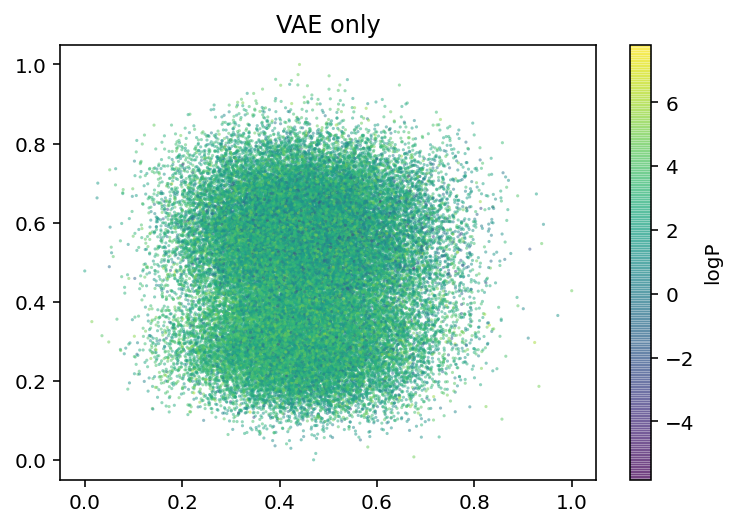

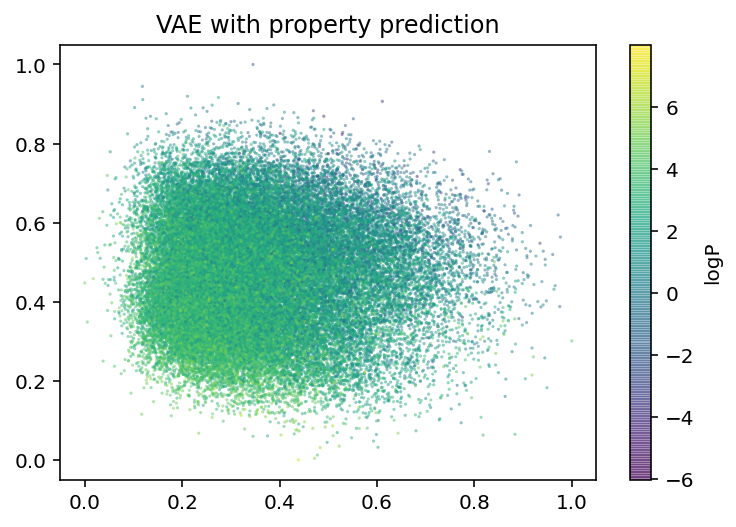

In [11]:
def pca_latent_vis(vae_model, prop_opt, title):
    Z, data, smiles = vae_model.ls_sampler_w_prop(size=50000,return_smiles=True)
    prop_df = pd.DataFrame(data).reset_index()
    prop_df['smiles']=smiles

    from sklearn.decomposition import PCA
    from sklearn.preprocessing import MinMaxScaler

    # do pca and normalize
    Z_pca = PCA(n_components=2).fit_transform(Z)
    Z_pca = MinMaxScaler().fit_transform(Z_pca)

    df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
    df.columns = ['x','y']
    df[prop_opt]=prop_df[prop_opt]

    scatter = plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    plt.colorbar(scatter, label=prop_opt)
    plt.title(title)
    plt.show()
    
pca_latent_vis(vae, "logP", "VAE only")
pca_latent_vis(vae_properties, "logP", "VAE with property prediction")

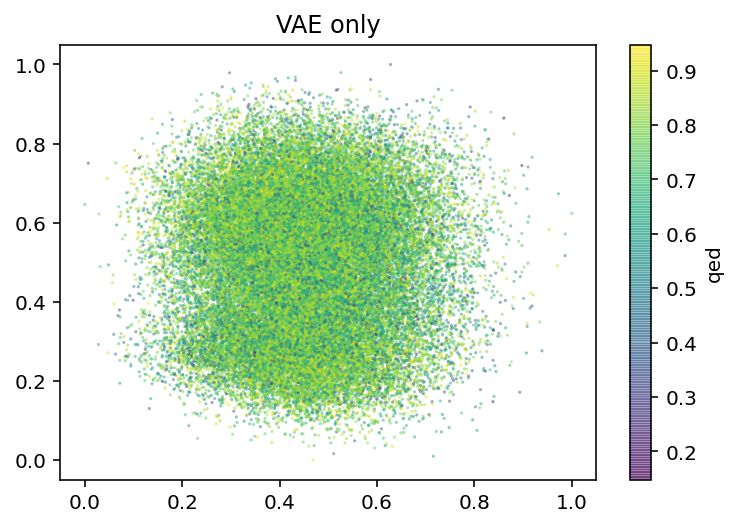

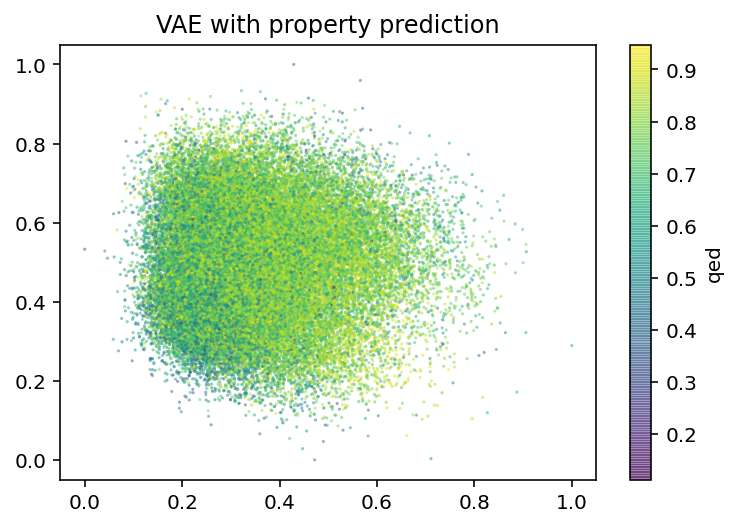

In [12]:
pca_latent_vis(vae, "qed", "VAE only")
pca_latent_vis(vae_properties, "qed", "VAE with property prediction")

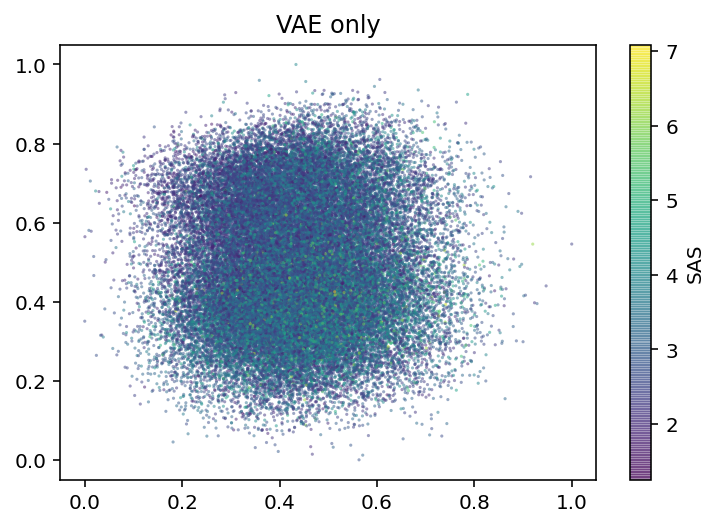

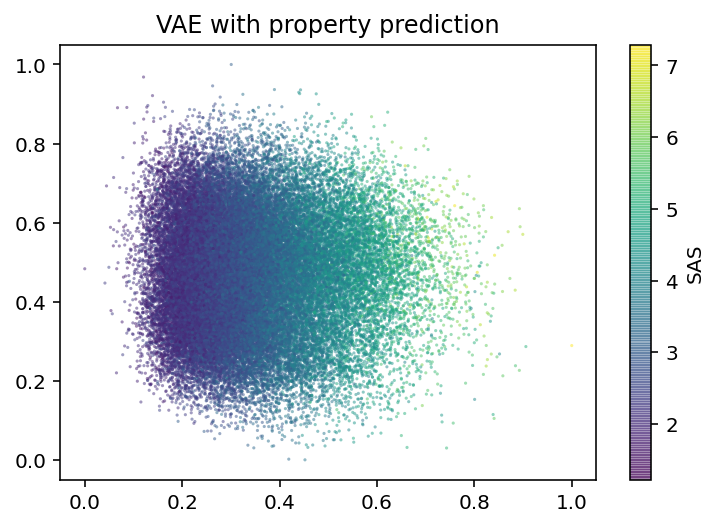

In [13]:
pca_latent_vis(vae, "SAS", "VAE only")
pca_latent_vis(vae_properties, "SAS", "VAE with property prediction")

### Table 1: Comparison of Molecule Generation Results to Original Datasets

![](../aux_data/tab1zinc.PNG)

In [14]:
# generate random by encoding 50 random molecules and decoding them 400 times
seed_size = 100

Z, _ = vae.ls_sampler_w_prop(size=seed_size)
generated_smiles = set()
for i in tqdm(range(Z.shape[0])):
    z = Z[i,:]
    decode_attempts = 400
    Z_tiled = np.tile(z, (decode_attempts, 1))
    X = vae.decode(Z_tiled)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z)

    generated_smiles.update(df["smiles"])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [08:58<00:00,  5.38s/it]


In [15]:
# generate molecules by decoding random gaussian noise
Z = np.random.normal(0, 1, (400, 196))
generated_smiles_random = set()
for i in tqdm(range(Z.shape[0])):
    z = Z[i,:]
    decode_attempts = 100
    Z_tiled = np.tile(z, (decode_attempts, 1))
    X = vae.decode(Z_tiled)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z)

    generated_smiles_random.update(df["smiles"])

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [10:01<00:00,  1.50s/it]


In [16]:
# ZINC dataset property stats
print(f"ZINC samples = {len(vae.data)}")
print(f"ZINC logP mean(std) = {vae.data['logP'].to_numpy().mean():.2f} ({vae.data['logP'].to_numpy().std():.2f})")
print(f"ZINC SAS mean(std) = {vae.data['SAS'].to_numpy().mean():.2f} ({vae.data['SAS'].to_numpy().std():.2f})")
print(f"ZINC QED mean(std) = {vae.data['qed'].to_numpy().mean():.2f} ({vae.data['qed'].to_numpy().std():.2f})")
print("-------------------------------------")

# VAE (encode-decode) generated dataset property stats
logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in generated_smiles:
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"VAE (encode-decode) samples = {len(generated_smiles)}")
logP_np = np.array(logP_vals)
print(f"VAE (encode-decode) logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"VAE (encode-decode) SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"VAE (encode-decode) QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")
print("-------------------------------------")

# VAE (random) generated dataset property stats
logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in generated_smiles_random:
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"VAE (random) samples = {len(generated_smiles_random)}")
logP_np = np.array(logP_vals)
print(f"VAE (random) logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"VAE (random) SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"VAE (random) QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")

ZINC samples = 249455
ZINC logP mean(std) = 2.46 (1.43)
ZINC SAS mean(std) = 3.05 (0.83)
ZINC QED mean(std) = 0.73 (0.14)
-------------------------------------
VAE (encode-decode) samples = 1076
VAE (encode-decode) logP mean(std) = 2.58(1.55)
VAE (encode-decode) SAS mean(std) = 3.49(0.95)
VAE (encode-decode) QED mean(std) = 0.69(0.13)
-------------------------------------
VAE (random) samples = 183
VAE (random) logP mean(std) = 2.40(1.76)
VAE (random) SAS mean(std) = 4.22(1.34)
VAE (random) QED mean(std) = 0.59(0.14)


### Table 2: MAE Prediction Error for Properties Using Various Methods on the ZINC and QM9 Datasets

![](../aux_data/tab2zinc.PNG)

In [17]:
# Compute MAE using unormalized properties gives us the results from the paper
Z, data = vae_properties.ls_sampler_w_prop(size=50000)
prop_df = pd.DataFrame(data).reset_index()

y_logp_mean = prop_df['logP'].to_numpy().mean()
y_qed_mean = prop_df['qed'].to_numpy().mean()

print(f"logP Mean MAE = {(np.abs(y_logp_mean - prop_df['logP'].to_numpy())).mean()}")
print(f"QED Mean MAE = {(np.abs(y_qed_mean - prop_df['qed'].to_numpy())).mean()}")

y_vae = vae_properties.predict_prop_Z(Z)
print(f"logP VAE MAE = {(np.abs(y_vae[:,2] - prop_df['logP'].to_numpy())).mean()}")
print(f"QED VAE MAE = {(np.abs(y_vae[:,0] - prop_df['qed'].to_numpy())).mean()}")

logP Mean MAE = 1.1450975539170558
QED Mean MAE = 0.11250775981689991
logP VAE MAE = 0.20779164156507196
QED VAE MAE = 0.07260222650068399
